In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from lib.mutation_util import date
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing (time filtering)

In [87]:
start_date = "2021-01-01"
end_date = "2021-11-30"

In [88]:
df_ori = pd.read_csv('../adyen-dataset.csv')
df_ori = df_ori.fillna("anonymous")

In [89]:
df_ori["date"] = df_ori.apply(date, axis=1)
df_ori["date"] = pd.to_datetime(df_ori["date"])
df_ori.set_index('date', inplace=True)
df_ts = df_ori.sort_index()

In [91]:
df_ts = df_ts.loc[start_date:end_date]

## Prepare panda edges (to feed to networkx)

In [92]:
# point_in is ip address, point_out is card number
edges1 = df_ts.groupby(["ip_address", "card_number"]).agg(total_transactions=('has_fraudulent_dispute', 'size'),
                                                          total_fraud=('has_fraudulent_dispute', 'sum')).reset_index()
edges1['type_in'] = 'ip'
edges1['type_out'] = 'card'
edges1.columns = ["point_in", "point_out", "total_transactions", "total_fraud", "type_in", "type_out"]

In [93]:
# point_in is ip address, point_out is email address
edges2 = df_ts.groupby(["ip_address", "email_address"]).agg(total_transactions=('has_fraudulent_dispute', 'size'),
                                                            total_fraud=(
                                                                'has_fraudulent_dispute', 'sum')).reset_index()
edges2['type_in'] = 'ip'
edges2['type_out'] = 'email'
edges2.columns = ["point_in", "point_out", "total_transactions", "total_fraud", "type_in", "type_out"]

In [94]:
edges3 = df_ts.groupby(["email_address", "card_number"]).agg(total_transactions=('has_fraudulent_dispute', 'size'),
                                                             total_fraud=(
                                                                 'has_fraudulent_dispute', 'sum')).reset_index()
edges3['type_in'] = 'email'
edges3['type_out'] = 'card'
edges3.columns = ["point_in", "point_out", "total_transactions", "total_fraud", "type_in", "type_out"]

In [95]:
df_edges = pd.concat([edges1, edges2, edges3], axis=0)
df_edges = df_edges[df_edges['total_transactions'] > 0]
df_edges

,point_in,point_out,total_transactions,total_fraud,type_in,type_out
0,--2E0toluie1TqMY-oXrQg,GOgdL2ymYoPD99nIT1zbkA,1,1,ip,card
1,--2E0toluie1TqMY-oXrQg,vtGsRvD7aYpa-LJdW8sbyg,8,5,ip,card
2,--9d913qAzBiBpd-6ti42g,X5g4bKG_F-dcnOGT865zCQ,1,0,ip,card
3,--OIdZguyqMXZdR9uwsVaA,ueS8t6SJZdHCumx81V1lTA,3,0,ip,card
4,--Q1vMw3s-7ckmVzxYbtRA,-u5HCYQ71snACmFJ99FUKw,2,0,ip,card
...,...,...,...,...,...,...
60608,zzl9fCinW9CkKIZtaRIkAA,dvtzLaNWVVDgMVSrUUilBQ,2,0,email,card
60609,zznixqMdaC80Mfrz9SgxRA,0Y5dHu16ZVyLhbBRarCbSA,2,0,email,card
60610,zznixqMdaC80Mfrz9SgxRA,PQhIPrnsTy12h6AxnwH9fg,1,0,email,card
60611,zzuPJQ385bLW-LfOxmkHDA,k19XpWxAkPdjX07LtKcWDw,1,0,email,card


## Build graph

In [96]:
import networkx as nx

source = 'point_in'
target = 'point_out'

G = nx.from_pandas_edgelist(df_edges, source=source, target=target, edge_attr=['total_transactions'])
print(f"number of nodes {len(G.nodes)}")
print(f"number of edges {len(G.edges)}")

number of nodes 142469
number of edges 206074


Text(0, 0.5, 'Frequency')

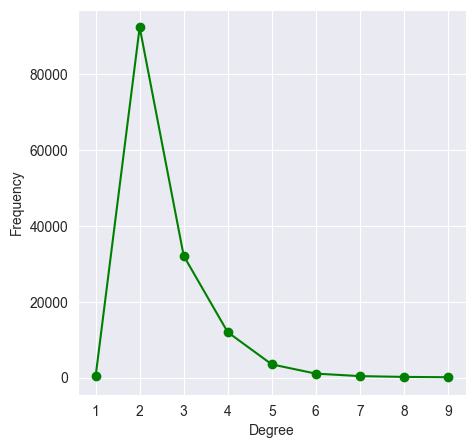

In [97]:
m = 1
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(5, 5))
plt.plot(degrees[m:10], degree_freq[m:10], 'go-')
plt.xlabel('Degree')
plt.ylabel('Frequency')

## Generate node degree feature
##### anonymous node degree replaced by 0

In [98]:
graph_features_lookup_table = pd.DataFrame(dict(
    DEGREE=dict(G.degree),
    EIGENVECTOR_CENTRALITY=nx.eigenvector_centrality_numpy(G),
    PAGE_RANK=nx.pagerank(G, alpha=0.9),
    # CLOSENESS_CENTRALITY = nx.closeness_centrality(G),
    # KATZ = nx.katz_centrality_numpy(G),
    # BETWEENNESS_CENTRALITY = nx.betweenness_centrality(G),
    # CLUSTCOEF = nx.clustering(G),
))
graph_features_lookup_table.index.name = "Node"
graph_features_lookup_table.to_csv(f"graph_features_lookup_table_{end_date}.csv", index=True)

In [99]:
df_graph_features = df_ts.loc(axis=1)["psp_reference", "ip_address", "email_address", "card_number"]
df_graph_features.reset_index(drop=True, inplace=True)

In [100]:
def lookup_graph_features_by_node(lookup_table, node):
    graph_features = lookup_table.loc(axis=0)[node]
    degree = graph_features["DEGREE"]
    eigen_centrality = graph_features["EIGENVECTOR_CENTRALITY"]
    page_rank = graph_features["PAGE_RANK"]
    if degree > 1000:
        degree = 0
    return degree, eigen_centrality, page_rank


def get_graph_features(row):
    ip_address = row[1]
    email_address = row[2]
    card_number = row[3]
    ip_address_features = lookup_graph_features_by_node(graph_features_lookup_table, ip_address)
    email_address_features = lookup_graph_features_by_node(graph_features_lookup_table, email_address)
    card_number_features = lookup_graph_features_by_node(graph_features_lookup_table, card_number)
    return ip_address_features, email_address_features, card_number_features

In [101]:
df_graph_features["graph_features_tuple"] = df_graph_features.apply(get_graph_features, axis=1)

In [102]:
df_graph_features[['ip_graph_features', 'email_graph_features', 'card_graph_features']] = pd.DataFrame(
    df_graph_features['graph_features_tuple'].tolist(), index=df_graph_features.index)

In [103]:
df_graph_features[['ip_node_degree', 'ip_eigen_centrality', 'ip_page_rank']] = pd.DataFrame(
    df_graph_features['ip_graph_features'].tolist(), index=df_graph_features.index)
df_graph_features[['email_node_degree', 'email_eigen_centrality', 'email_page_rank']] = pd.DataFrame(
    df_graph_features['email_graph_features'].tolist(), index=df_graph_features.index)
df_graph_features[['card_node_degree', 'card_eigen_centrality', 'card_page_rank']] = pd.DataFrame(
    df_graph_features['card_graph_features'].tolist(), index=df_graph_features.index)

In [104]:
df_graph_features.drop(
    ["ip_address", "email_address", "card_number", "graph_features_tuple", "ip_graph_features", "email_graph_features",
     "card_graph_features"], axis=1, inplace=True)

In [105]:
df_graph_features

,psp_reference,ip_node_degree,ip_eigen_centrality,ip_page_rank,email_node_degree,email_eigen_centrality,email_page_rank,card_node_degree,card_eigen_centrality,card_page_rank
0,31441792706,2.0,1.073674e-19,0.000007,2.0,-5.868666e-19,0.000007,2.0,7.124332e-20,0.000007
1,56840734687,2.0,-5.874083e-19,0.000005,3.0,9.492551e-19,0.000009,3.0,2.177341e-20,0.000009
2,50841350701,4.0,3.184363e-03,0.000008,6.0,2.868798e-05,0.000013,4.0,3.184363e-03,0.000008
3,81202637637,2.0,-5.664253e-19,0.000007,2.0,1.385103e-20,0.000007,2.0,-3.899287e-19,0.000007
4,76149360397,2.0,2.855703e-05,0.000005,3.0,3.184298e-03,0.000006,3.0,3.184298e-03,0.000006
...,...,...,...,...,...,...,...,...,...,...
127045,61422715805,0.0,7.069276e-01,0.094519,2.0,3.184169e-03,0.000004,2.0,3.184169e-03,0.000004
127046,62714194430,3.0,2.862540e-05,0.000006,2.0,1.440889e-05,0.000004,7.0,3.184748e-03,0.000014
127047,77364072877,2.0,-1.898964e-19,0.000005,3.0,-4.003480e-19,0.000009,3.0,7.563610e-20,0.000009
127048,58757695028,2.0,2.170573e-19,0.000007,2.0,-5.845331e-19,0.000007,2.0,-5.047551e-20,0.000007


In [106]:
df_graph_features.to_csv(f"graph_features_{end_date}.csv", index=False)

In [129]:
import networkx as nx
G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_edge(1,2,weight=1)
G.add_edge(2,3,weight=1)
G.add_edge(1,3,weight=1)

In [130]:
dict(G.degree)

{1: 2, 2: 2, 3: 2}

In [131]:
nx.pagerank(G)

{1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333}

In [132]:
nx.eigenvector_centrality(G)


{1: 0.5773502691896258, 2: 0.5773502691896258, 3: 0.5773502691896258}